In [1]:
%matplotlib inline

In [2]:
from pylab import *
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120
import matplotlib.patches as patches


In [3]:
data = loadtxt('results.dat')
x0, y0, z0, vx0, vy0, vz0 = data[:,:6].T
x,  y,  z,  vx,  vy,  vz = data[:,6:].T

d = sqrt(x**2 + y**2)
vd = (x*vx + y*vy)/d
vt = (x*vy - y*vx)/d

d0 = sqrt(x0**2 + y0**2)
vd0 = (x0*vx0 + y0*vy0)/d0
vt0 = (x0*vy0 - y0*vx0)/d0


target_pos = array([-9.1817914423447837E+03, -2.3161972143758221E+03,  4.2321813890923086E+03]) # pc
target_vel = array([ 1.6995805137819784E+02,  1.3476658021349482E+02, -1.3342192079702110E+02]) # km/s
target_pos *= 0.001 # Now in kpc
target_vel *= 1.0226911647958985 # Now in kpc/Gyr

target_x,  target_y,  target_z  = target_pos
target_vx, target_vy, target_vz = target_vel
target_d = sqrt(target_x**2 + target_y**2)
target_vd = (target_x*target_vx + target_y*target_vy)/target_d
target_vt = (target_x*target_vy - target_y*target_vx)/target_d

In [4]:
def density_map(x, y, q=None, bin_edges=None, n_bins=32, log=False, **kargs):
    if bin_edges is None:
        x_min, x_max = x.min(), x.max()
        y_min, y_max = y.min(), y.max()
        x_bin_edges = linspace(x_min, x_max, n_bins+1)
        y_bin_edges = linspace(y_min, y_max, n_bins+1)
    else:
        x_bin_edges, y_bin_edges = bin_edges
        x_min, x_max = x_bin_edges[0], x_bin_edges[-1]
        y_min, y_max = y_bin_edges[0], y_bin_edges[-1]
    counts, _, _ = histogram2d(x, y, bins=[x_bin_edges, y_bin_edges])
    if not q is None:
        value,  _, _ = histogram2d(x, y, bins=[x_bin_edges, y_bin_edges], weights=q)
        counts[counts==0] = nan
        value /= counts
    else: value = counts
    if log: value = log10(value)
    return imshow(rot90(value), extent=[x_min, x_max, y_min, y_max], **kargs)

/home/meiron/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


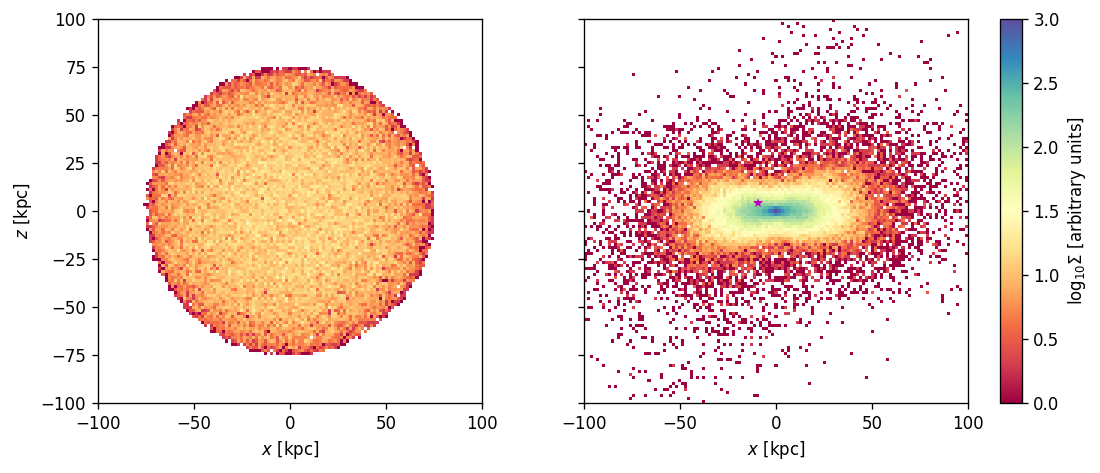

In [5]:
figsize = rcParams['figure.figsize']
fig = figure(figsize=[figsize[0]*1.5, figsize[1]])

subplot(121)
bin_edges = linspace(-100,100,128)
density_map(x0, z0, bin_edges=[bin_edges, bin_edges], log=True, cmap='Spectral', vmin=0, vmax=3)
xlabel('$x$ [kpc]')
ylabel('$z$ [kpc]')
subplot(122)
image = density_map(x, z, bin_edges=[bin_edges, bin_edges], log=True, cmap='Spectral', vmin=0, vmax=3)
gca().set_yticklabels([])
xlabel('$x$ [kpc]')
plot(target_x, target_z, 'm*', mew=0)
subplots_adjust(left=0.075, bottom=0.15, top=0.95, right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.8])
cbar = fig.colorbar(image, cax=cbar_ax)
cbar.set_label('$\log_{10} \Sigma$ [arbitrary units]')
savefig('initial_and_final_projected_densities.png')

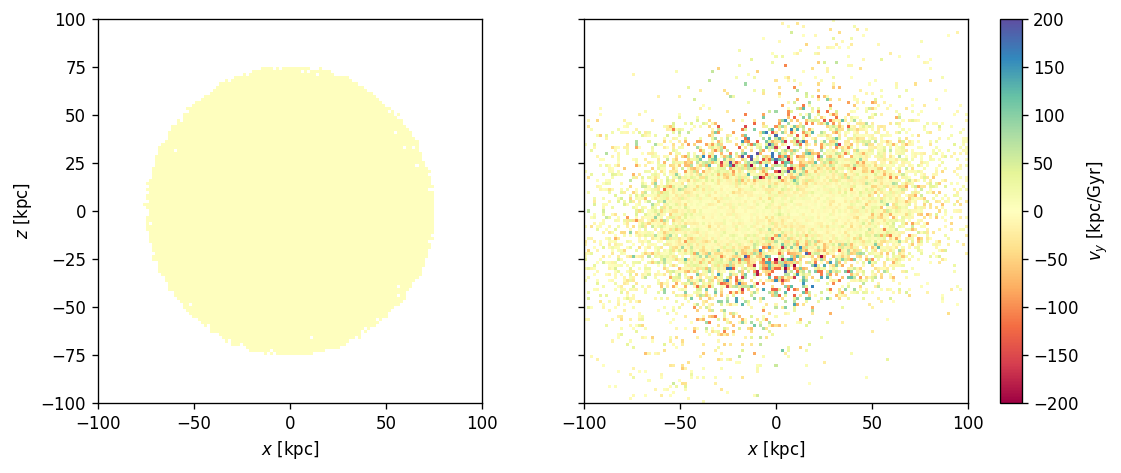

In [6]:
figsize = rcParams['figure.figsize']
fig = figure(figsize=[figsize[0]*1.5, figsize[1]])

subplot(121)
bin_edges = linspace(-100,100,128)
density_map(x0, z0, q=vy0, bin_edges=[bin_edges, bin_edges], log=False, cmap='Spectral', vmin=-200, vmax=200)
xlabel('$x$ [kpc]')
ylabel('$z$ [kpc]')
subplot(122)
image = density_map(x, z, q=vy, bin_edges=[bin_edges, bin_edges], log=False, cmap='Spectral', vmin=-200, vmax=200)
gca().set_yticklabels([])
xlabel('$x$ [kpc]')
subplots_adjust(left=0.075, bottom=0.15, top=0.95, right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.8])
cbar = fig.colorbar(image, cax=cbar_ax)
cbar.set_label('$v_y$ [kpc/Gyr]')
savefig('check_for_systematic_rotation.png')

In [7]:
import ellipsoids
Q = ellipsoids.quadrupole_tensor(x, y, z)
eigenvalues, eigenvectors = np.linalg.eig(Q)
i = np.argsort(eigenvalues)
print('Ellipsoid aspect ratios:')
print('b/a  = %8.4f' % (np.sqrt(eigenvalues[i[1]]/eigenvalues[i[2]])))
print('c/a  = %8.4f' % (np.sqrt(eigenvalues[i[0]]/eigenvalues[i[2]])))
R = ellipsoids.rotation_matrix_from_eigenvectors(eigenvectors, eigenvalues)
direction = R[2,:]
if direction[2] < 0: direction = -direction
theta = arccos(direction[2]/linalg.norm(direction))
phi   = arctan2(direction[1], direction[0])
print('\nEllipsoid minor axis dirction:')
print('θ    = %8.4f°' % rad2deg(theta))
print('ϕ    = %8.4f°' % rad2deg(phi))

import scipy.optimize
def miyamoto_nagai_params_from_medians(m_d, m_z):
    m_d_pred = lambda x: exp(1.43475163 + (1.04827148*log(x)-1.09023112)*(arctan(log(x)/2.30939056)/pi+0.5))
    m_z_pred = lambda x: 5.77340E-01*x
    b_over_a = scipy.optimize.brentq(lambda x: m_d_pred(x)/m_z_pred(x)-m_d/m_z, 1/64, 64)
    a1 = m_d/m_d_pred(b_over_a)
    a2 = m_z/m_z_pred(b_over_a)
    a = 0.5*(a1 + a2)
    b = a*b_over_a
    return a, b

m_z = median(abs(z))
m_d = median(sqrt(x**2+y**2))
a_mn, b_mn = miyamoto_nagai_params_from_medians(m_d, m_z)
print('\nMiyamoto-Nagai parameters from medians:')
print('a_mn = %8.4f [kpc]' % a_mn)
print('b_mn = %8.4f [kpc]' % b_mn)

Ellipsoid aspect ratios:
b/a  =   0.9156
c/a  =   0.4693

Ellipsoid minor axis dirction:
θ    =   8.0773°
ϕ    = 144.3822°

Miyamoto-Nagai parameters from medians:
a_mn =  10.1346 [kpc]
b_mn =   7.1859 [kpc]


Text(0, 0.5, '$r_\\mathrm{final}$ [kpc]')

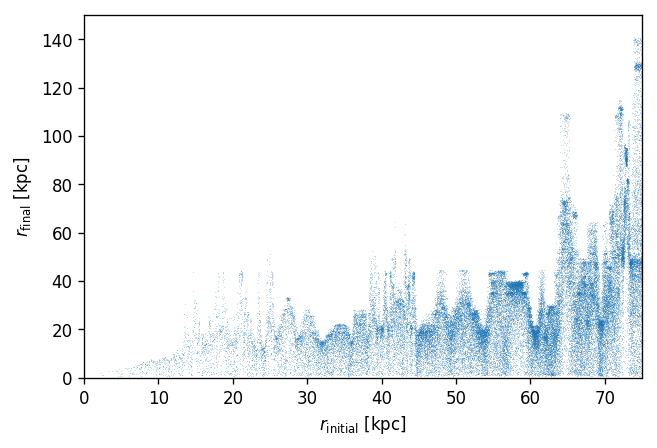

In [8]:
r  = sqrt(x**2  + y**2  + z**2)
r0 = sqrt(x0**2 + y0**2 + z0**2)
plot(r0, r, ',', alpha=0.25)
xlim(0,75)
ylim(0,150)
xlabel('$r_\mathrm{initial}$ [kpc]')
ylabel('$r_\mathrm{final}$ [kpc]')

In [10]:
len(x)

65403

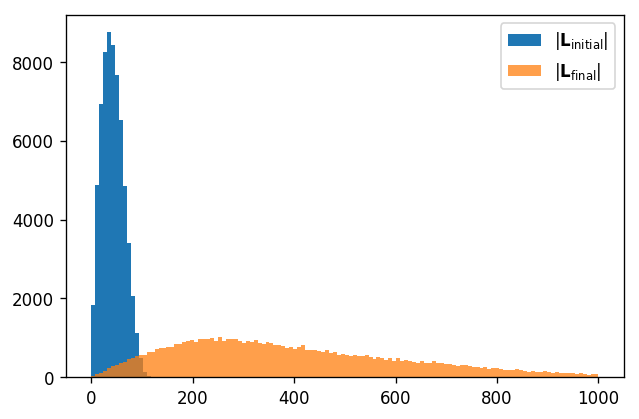

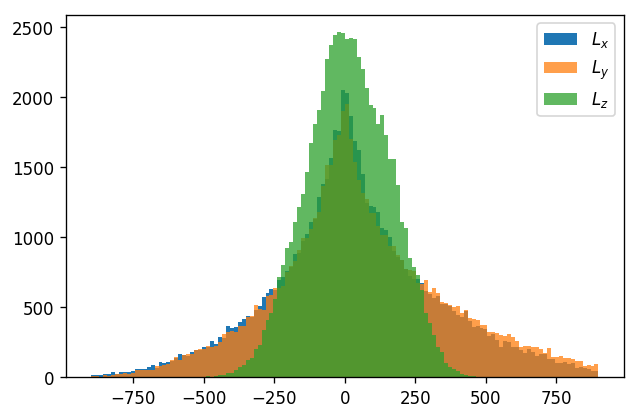

In [9]:
X0 = r_[[x0],[y0],[z0]].T
X  = r_[[x ],[y ],[z ]].T
V0 = r_[[vx0],[vy0],[vz0]].T
V  = r_[[vx ],[vy ],[vz ]].T
L0 = cross(X0, V0)
L  = cross(X , V )
L0_mag = linalg.norm(L0, axis=1)
L_mag  = linalg.norm(L, axis=1)
bin_edges = linspace(0, 1000, 129)
hist(L0_mag, bins=bin_edges);
hist(L_mag,  bins=bin_edges, alpha=0.75);
legend(('$|\mathbf{L}_\mathrm{initial}|$', '$|\mathbf{L}_\mathrm{final}|$'))
figure()
bin_edges = linspace(-900, 900, 129)
hist(L [:,0], bins=bin_edges, alpha=1.00);
hist(L [:,1], bins=bin_edges, alpha=0.75);
hist(L [:,2], bins=bin_edges, alpha=0.75);
legend(('$L_x$', '$L_y$', '$L_z$'))